In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df = pd.read_csv("ex2data2.txt", names=['test1', 'test2', 'status'])
df.head()

,test1,test2,status
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


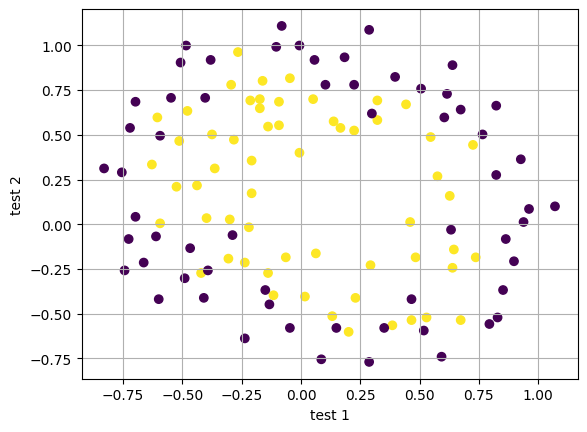

In [4]:
plt.scatter(df['test1'], df['test2'], c = df['status'])
plt.xlabel('test 1')
plt.ylabel('test 2')
plt.grid(True)

In [5]:
x = df[['test1', 'test2']].values

def normalize(x):
  std_fixed = np.zeros_like(np.std(x, axis=0))
  std_fixed[np.std(x, axis=0) == 0] = 1
  std_fixed += np.std(x, axis=0)
  return (x - np.mean(x, axis=0))/std_fixed, np.mean(x, axis=0), np.std(x, axis=0)

poly = PolynomialFeatures(30)
x = poly.fit_transform(x)
x[:,1:], mean, std = normalize(x[:,1:])
mean = np.insert(mean, 0, 0)
std = np.insert(std, 0, 1)

y = df['status'].values
y = y.reshape((-1, 1))

In [6]:
def g(z):
    return 1/(1 + np.exp(-z))
def h(theta, x):
    return g(x.dot(theta))
def loss_func(theta, x, y):
    return (-1/y.size *(y.T.dot(np.log(h(theta, x))) + (1-y).T.dot(np.log(1-h(theta,x))))).mean()

In [8]:
x_train, x_rest, y_train, y_rest = train_test_split(x, y, train_size=0.6,shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.75, shuffle=True, random_state=42)
print(y_train.shape, y_val.shape, y_test.shape)

(70, 1) (36, 1) (12, 1)


In [9]:
def loss_func_reg(theta, x, y, l):
    return loss_func(theta, x, y) + l/(2*y.size)*(theta[1:]**2).sum()

In [10]:
def grad_desc(loss_func_reg, theta, x, y, a, l, iterations = 50000):
    m = y.size

    for _ in range(iterations): 
        h = g(x.dot(theta))
        gradient = x.T.dot(h - y)/m
        theta[0] -= a*gradient[0]
        theta[1:] = theta[1:]*(1-l*a/m) - a*gradient[1:]

    return theta

In [38]:
lambdas = np.linspace(0, 10, 60)
theta_res = np.zeros((x_train.shape[1], 1))
min_loss_val = loss_func(theta_res, x_val, y_val)
l_min = 0
val_losses = []
train_losses = []
for l in lambdas:
    theta = np.zeros((x_train.shape[1], 1))
    theta = grad_desc(loss_func_reg, theta, x_train, y_train, 0.5, l)
    curr_loss_val = loss_func(theta, x_val, y_val)
    val_losses.append(curr_loss_val)
    train_losses.append(loss_func(theta, x_train, y_train))
    if curr_loss_val < min_loss_val:
        theta_res[:,:] = theta[:,:]
        min_loss_val = curr_loss_val
        l_min = l

/tmp/ipykernel_226806/3886835342.py:6: RuntimeWarning: divide by zero encountered in log
  return (-1/y.size *(y.T.dot(np.log(h(theta, x))) + (1-y).T.dot(np.log(1-h(theta,x))))).mean()


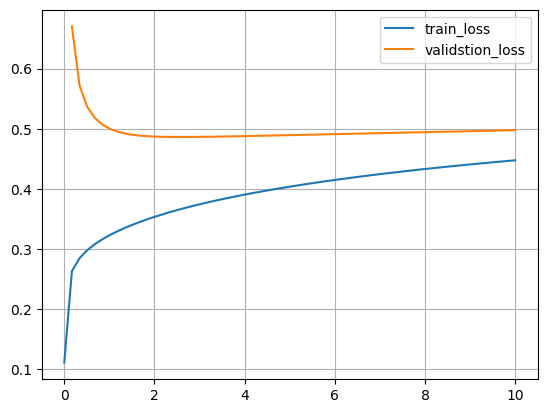

In [40]:
plt.plot(lambdas, train_losses, label='train_loss')
plt.plot(lambdas, val_losses, label='validstion_loss')
plt.legend()
plt.grid(True)

In [33]:
print(f"lambda = {l_min}, min_loss_val = {min_loss_val}")

lambda = 2.526315789473684, min_loss_val = 0.4863327767973226


In [34]:
def accuracy(theta, x, h, y):
    temp = 0
    for i in range(y.size):
        if h(theta, x[i]).mean().round() ==  y[i]:
            temp += 1
    return temp/y.size

In [35]:
print(f'Точность на тренировочной выборке составляет {accuracy(theta_res, x_train, h, y_train)*100 :.2f}%')
print(f'Точность на валидационной выборке составляет {accuracy(theta_res, x_val, h, y_val)*100 :.2f}%')
print(f'Точность на тестовой выборке составляет {accuracy(theta_res, x_test, h, y_test)*100 :.2f}%')

Точность на тренировочной выборке составляет 82.86%
Точность на валидационной выборке составляет 72.22%
Точность на тестовой выборке составляет 83.33%
